### notebook purpose

- evaluate mask types across...
    - square v rect central region
    - different sampling patterns across e1, e2

In [12]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics_imgs, plot_row_qdess, scale_0_1
from utils.data_io import get_mtr_ids_and, load_imgs, load_qdess
from utils.transform import reshape_adj_channels_to_complex_vals, \
                            reshape_complex_vals_to_adj_channels

### DELETE later: img loader specific to `many_inits/` expmt

In [67]:
def load_imgs_many_inits(mtr_id_list, path, num_inits=None):
    ''' load images where each sample was reconed multiple times 
        num_inits to control how many restarts are loaded '''

    # indicator string if loading gt
    gt_str = '_gt' if '/gt/' in path else ''

    num_samps = len(mtr_id_list)
    if num_inits == None:
        num_inits = 4
    num_echos, num_y, num_z = 2, 512, 160
    arr = np.empty((num_samps, num_inits, num_echos, num_y, num_z))

    for idx_s, mtr_id in enumerate(mtr_id_list):
        
        for idx_i in np.arange(num_inits):

            arr[idx_s, idx_i, 0] = np.load('{}MTR_{}_e1{}_init{}.npy'.format(path, mtr_id, gt_str, idx_i))
            arr[idx_s, idx_i, 1] = np.load('{}MTR_{}_e2{}_init{}.npy'.format(path, mtr_id, gt_str, idx_i))

    return arr

In [61]:
accel = 4
path_base = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

path_gt = path_base + 'gt/'
# path_bl = path_base + 'baseline/'
# path_new = path_base + 'many_inits/iter_10k/'

path_bl = path_base + 'many_inits/iter_10k/'
path_new = path_base + 'many_inits/iter_5k/'

### load imgs, calc metrics

In [68]:
# mtr_id_list = get_mtr_ids_and(path_bl, path_new)
mtr_id_list = ['005', '006', '030']

imgs_gt = load_imgs(mtr_id_list, path=path_gt)

# imgs_bl = load_imgs(mtr_id_list, path=path_bl)
if 'many_inits' in path_bl:
    imgs_bl = load_imgs_many_inits(mtr_id_list, path_bl, num_inits=2)
    imgs_bl = np.mean(imgs_bl, axis=1) #avg across init
else:
    imgs_bl = load_imgs(mtr_id_list, path=path_new)

# imgs_new = load_imgs(mtr_id_list, path=path_new)
if 'many_inits' in path_new:
    imgs_new = load_imgs_many_inits(mtr_id_list, path_new, num_inits=4)
    imgs_new = np.mean(imgs_new, axis=1) #avg across init
else:
    imgs_new = load_imgs(mtr_id_list, path=path_new)
    
metrics_bl = calc_metrics_imgs(imgs_gt, imgs_bl)
metrics_new = calc_metrics_imgs(imgs_gt, imgs_new)

### avg metrics across all samples

In [69]:
print(mtr_id_list)

mu_bl = np.around(np.mean(metrics_bl, 0), 4)
mu_new = np.around(np.mean(metrics_new, 0), 4)
mu_diff = mu_new - mu_bl
print(mu_bl, '\n', mu_new, '\n', mu_diff)

['005', '006', '030']
[[ 0.9045  0.9801  0.9034 34.9456]
 [ 0.7361  0.9552  0.832  34.6741]] 
 [[ 0.9052  0.9833  0.9143 35.6039]
 [ 0.7662  0.9639  0.8532 35.4201]] 
 [[7.000e-04 3.200e-03 1.090e-02 6.583e-01]
 [3.010e-02 8.700e-03 2.120e-02 7.460e-01]]


### delete me below: print stuff

In [50]:
mu_diff_2 = mu_diff

In [53]:
mu_diff_4 = mu_diff

In [54]:
# ~70% of gain w 2 samples on accel 8

In [55]:
print(mu_diff_2, '\n', mu_diff_4)

[[0.0109 0.0061 0.0267 1.0754]
 [0.0263 0.0087 0.0269 0.8386]] 
 [[0.014  0.0092 0.0388 1.6784]
 [0.0336 0.0133 0.0411 1.3013]]


In [56]:
mu_diff_2 / mu_diff_4

array([[0.77857143, 0.66304348, 0.68814433, 0.64072927],
       [0.7827381 , 0.65413534, 0.65450122, 0.64443249]])

In [ ]:
[[0.0109 0.0061 0.0267 1.0754]
 [0.0263 0.0087 0.0269 0.8386]]

### indiv sample metrics

In [16]:
for idx_s, mtr_id in enumerate(mtr_id_list):
    
    print(mtr_id)
    print(metrics_bl[idx_s])
    print(metrics_new[idx_s])
    sys.exit()

005
[[ 0.8607  0.9619  0.8307 31.2403]
 [ 0.5459  0.9     0.6819 30.1073]]
[[ 0.8633  0.9567  0.8091 30.7887]
 [ 0.552   0.8983  0.6574 30.0567]]


SystemExit: 

### plot

SystemExit: 

/home/vanveen/heck/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


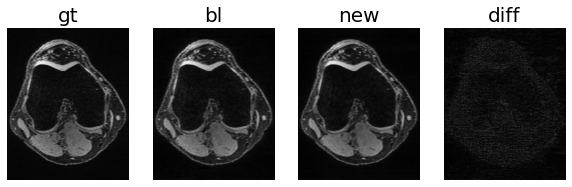

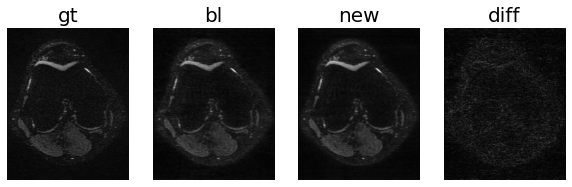

In [21]:
title_list = ['gt', 'bl', 'new']
clim_list = [None] * len(title_list)
DIFF_MAP = True

for idx_s in np.arange(imgs_gt.shape[0]):
    for idx_e in np.arange(imgs_gt.shape[1]):
        
        im_gt, im1, im2 = imgs_gt[idx_s, idx_e], \
                          imgs_bl[idx_s, idx_e], \
                          imgs_new[idx_s, idx_e]
#         im_gt, im1, im2 = scale_0_1(im_gt), scale_0_1(im1), scale_0_1(im2)
        arr_list = [im_gt, im1, im2]
        
        if DIFF_MAP:
            C = 4 # constant for plotting on clim=(0,1)
            im_diff = C * np.abs(scale_0_1(im1) - scale_0_1(im2))
            arr_list.append(im_diff)
            title_list.append('diff')
            clim_list.append((0,1))
                
        plot_row_qdess(arr_list, title_list, clim_list)
        
    sys.exit()